In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import math

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

from sklearn.exceptions import ConvergenceWarning
import warnings
import os

warnings.filterwarnings("ignore", category=ConvergenceWarning)
np.NINF = -np.inf

In [2]:
df = pd.read_csv('data_preprocessed.csv',index_col=0)

In [3]:
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

In [4]:
df.head()

,LotFrontage,LotShape,LandSlope,OverallQual,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional_Sev,Functional_Typ,MasVnrType_BrkFace,MasVnrType_Stone,GarageType_Detached,GarageType_Other,Foundation_Modern,Foundation_Standard,Neighborhood_Low,Neighborhood_Mid
0,-0.081048,0,0,0.666667,-1.042902,-0.869643,2,2,3,1,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.556103,0,0,0.555556,-0.183402,0.390007,1,2,3,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.057249,1,0,0.666667,-0.976787,-0.821195,2,2,3,1,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.326149,1,0,0.666667,1.800059,0.632247,1,2,2,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.706068,1,0,0.777778,-0.943729,-0.724299,2,2,3,1,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Redundancy χαρακτηριστικών

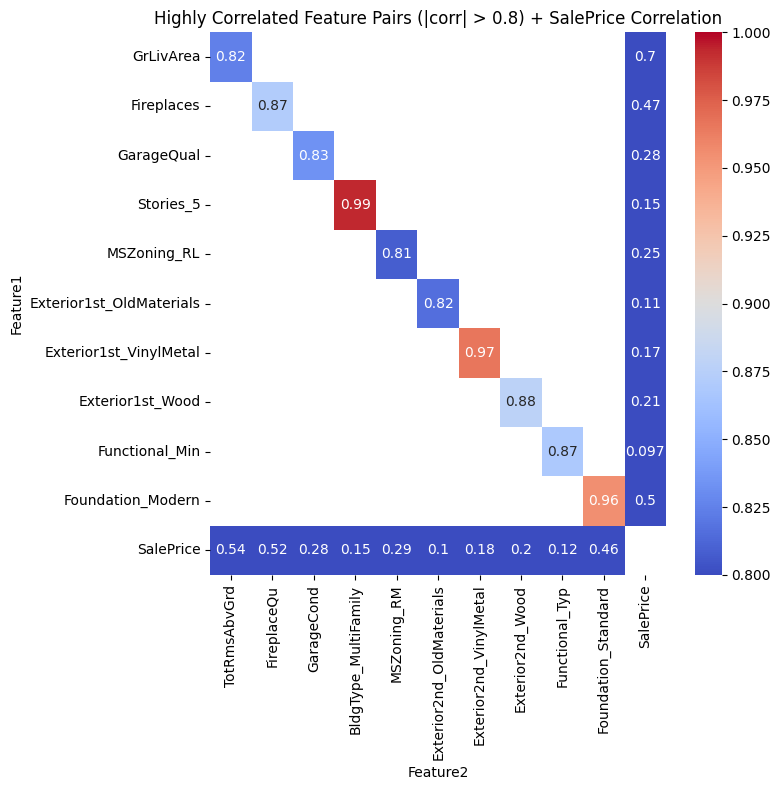

In [5]:
corr_matrix = df.corr().abs()

# Upper triangle (αποφυγή duplicate pairs)
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
filtered_corr = corr_matrix.where(upper)

# high correlated > 0.8
high_corr_pairs = filtered_corr.stack()[filtered_corr.stack() > 0.8]
high_corr_df = high_corr_pairs.reset_index()
high_corr_df.columns = ['Feature1', 'Feature2', 'Correlation']

# unique features για rows και columns
row_features = high_corr_df['Feature1'].unique()
col_features = high_corr_df['Feature2'].unique()
col_features = [f for f in col_features if f not in row_features]

# όλα τα χαρακτηριστικά που μας ενδιαφέρουν για correlation με SalePrice
involved_features = pd.unique(high_corr_df[['Feature1', 'Feature2']].values.ravel('K'))
saleprice_corr = df[involved_features].corrwith(df['SalePrice']).abs()

pivot = high_corr_df.pivot(index='Feature1', columns='Feature2', values='Correlation')
# Reindex για να περιλαμβάνονται μόνο τα rows και columns που μας ενδιαφέρουν
pivot = pivot.reindex(index=row_features, columns=col_features)

# SalePrice column για row features και column features
pivot['SalePrice'] = saleprice_corr[row_features]
pivot.loc['SalePrice'] = saleprice_corr[col_features].reindex(col_features)

# plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(pivot, annot=True, cmap='coolwarm', vmin=0.8, vmax=1)
plt.title("Highly Correlated Feature Pairs (|corr| > 0.8) + SalePrice Correlation")
plt.tight_layout()
plt.savefig(f"{plot_dir}/pearson_corr.png", bbox_inches ='tight')
plt.show()

In [6]:
high_corr_pairs

GrLivArea                 TotRmsAbvGrd                0.824600
Fireplaces                FireplaceQu                 0.871778
GarageQual                GarageCond                  0.833057
Stories_5                 BldgType_MultiFamily        0.993597
MSZoning_RL               MSZoning_RM                 0.808560
Exterior1st_OldMaterials  Exterior2nd_OldMaterials    0.816274
Exterior1st_VinylMetal    Exterior2nd_VinylMetal      0.965996
Exterior1st_Wood          Exterior2nd_Wood            0.878032
Functional_Min            Functional_Typ              0.868179
Foundation_Modern         Foundation_Standard         0.955396
dtype: float64

In [7]:
# features_to_drop τα χαρακτηριστικα με τα μικρότερο pearson correlation με το target
features_to_drop = []

for f1, f2 in high_corr_pairs.index:
    corr1 = df[[f1, "SalePrice"]].corr().iloc[1,0]
    corr2 = df[[f2, "SalePrice"]].corr().iloc[1,0]
    if corr1>corr2:
        features_to_drop.append(f2)
        continue
    features_to_drop.append(f1)

In [8]:
features_to_drop

['TotRmsAbvGrd',
 'Fireplaces',
 'GarageQual',
 'BldgType_MultiFamily',
 'MSZoning_RM',
 'Exterior1st_OldMaterials',
 'Exterior1st_VinylMetal',
 'Exterior1st_Wood',
 'Functional_Min',
 'Foundation_Standard']

In [9]:
df.drop(list(features_to_drop), axis=1, inplace=True)

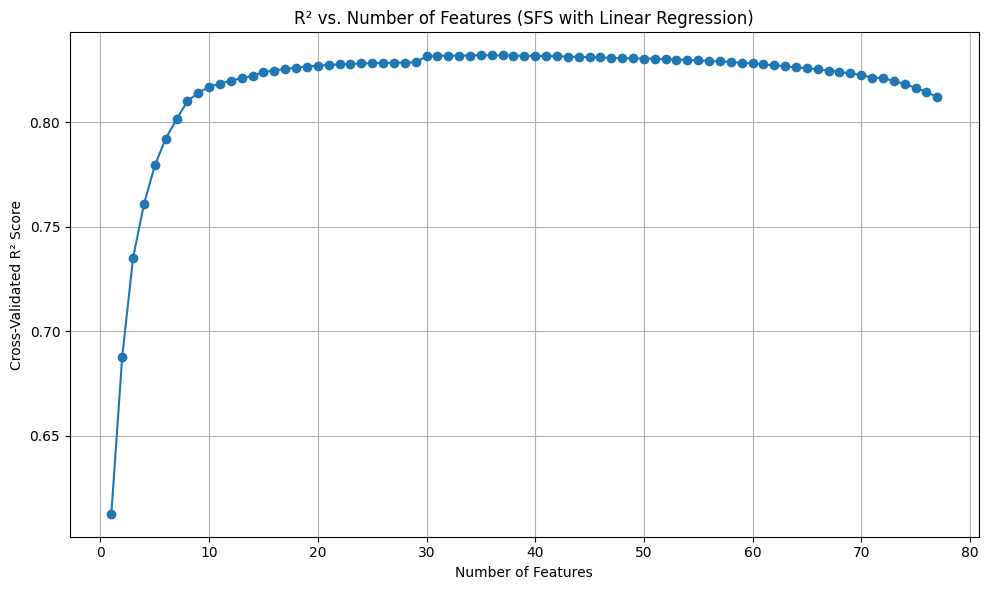

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df[[col for col in df.columns if col != 'SalePrice']],
                                                   df["SalePrice"],
                                                   train_size=0.8,
                                                   random_state=42)

# SFS, σε όλο το feature space
sfs = SFS(
    estimator=LinearRegression(),
    k_features='best',
    forward=True,
    floating=False,
    scoring='r2',
    cv= 5,
    n_jobs=-1
)

sfs = sfs.fit(X_train, y_train)

# R² scores κάθε βήματος
r2_scores = list(sfs.get_metric_dict().values())
r2_vals = [step['avg_score'] for step in r2_scores]
feature_counts = list(range(1, len(r2_vals) + 1))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, r2_vals, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated R² Score')
plt.title('R² vs. Number of Features (SFS with Linear Regression)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{plot_dir}/sfs.png", bbox_inches ='tight')
plt.show()

In [12]:
r2_vals = np.array(r2_vals)

max_ = r2_vals.max()
argmax = r2_vals.argmax()

In [13]:
feat_30 = [feature for feature in sfs.subsets_[30]['feature_names'] if feature not in sfs.subsets_[29]['feature_names']]
feat_29 = [feature for feature in sfs.subsets_[29]['feature_names'] if feature not in sfs.subsets_[28]['feature_names']]
r2_imp_29 = r2_vals[28] - r2_vals[27]
r2_imp_30 = r2_vals[29] - r2_vals[28]
print(f"Χαρακτηριστικό νούμερο 29: {feat_29[0]} βελτίωση R²: {round(r2_imp_29,5)}")
print(f"Χαρακτηριστικό νούμερο 30: {feat_30[0]}, βελτίωση R²: {round(r2_imp_30,4)}")

Χαρακτηριστικό νούμερο 29: SaleCondition_Normal βελτίωση R²: 5e-05
Χαρακτηριστικό νούμερο 30: SaleCondition_NonNormal, βελτίωση R²: 0.003


In [14]:
print(f"Best number of features {argmax}, average cv R²: {round(max_,4)}")

Best number of features 34, average cv R²: 0.832


In [15]:
selected_features_34 = list(sfs.subsets_[34]['feature_names'])

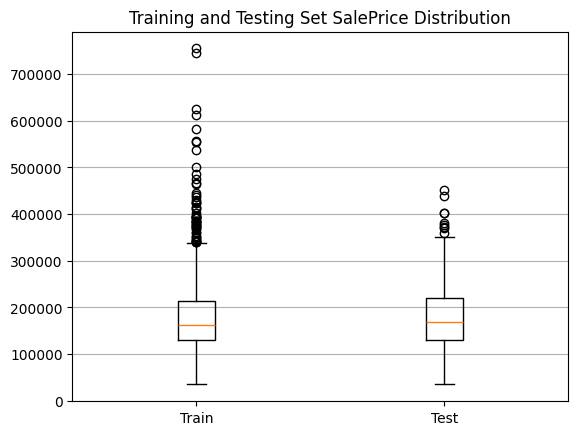

In [16]:
# διαφορά στην κατανομή του training και του test target
plt.boxplot([y_train, y_test], vert=True, tick_labels=['Train', 'Test'])
plt.title('Training and Testing Set SalePrice Distribution')
plt.grid(axis='y')
plt.savefig(f"{plot_dir}/train_test_dist.png", bbox_inches ='tight')
plt.show()

## Linear Regression

In [17]:
kf = KFold(n_splits=10)
lr = LinearRegression()

scores = cross_val_score(lr, X_train[selected_features_34], y_train, cv=kf)
print(round(scores.mean().item(),3), '±', round(scores.std().item(),3))

0.836 ± 0.044


In [18]:
lr.fit(X_train[selected_features_34], y_train)
round(lr.score(X_train[selected_features_34], y_train), 3)

0.842

In [19]:
round(lr.score(X_test[selected_features_34], y_test), 3)

0.87

In [20]:
y_pred = lr.predict(X_test[selected_features_34])
residuals = y_pred - y_test

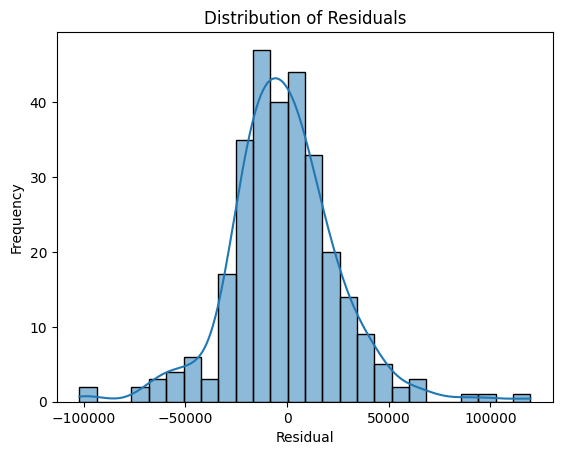

In [21]:
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.savefig(f"{plot_dir}/residual_dist.png", bbox_inches ='tight')

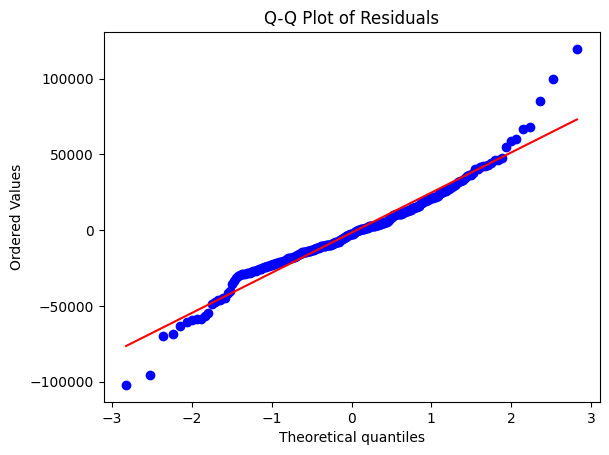

In [22]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.savefig(f"{plot_dir}/qqplot.png", bbox_inches ='tight')

In [23]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

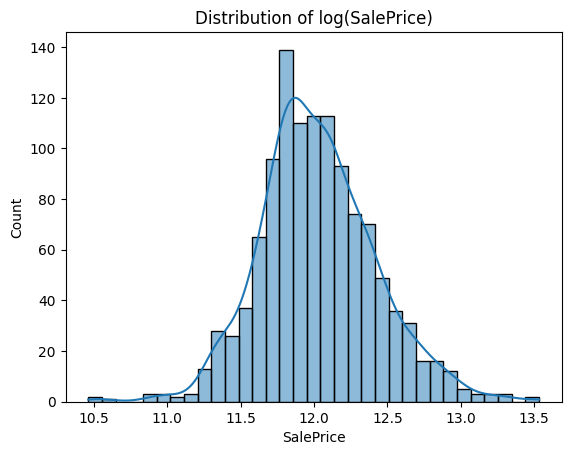

In [24]:
sns.histplot(y_train_log, kde=True)
plt.title("Distribution of log(SalePrice)")
plt.savefig(f"{plot_dir}/logSalePrice_dist.png")

In [25]:
scores = cross_val_score(lr, X_train[selected_features_34], y_train_log, cv=kf)
print(round(scores.mean().item(),3), '±', round(scores.std().item(),3))

0.889 ± 0.026


In [26]:
lr.fit(X_train[selected_features_34], y_train_log)
round(lr.score(X_train[selected_features_34], y_train_log), 3)

0.897

In [27]:
round(lr.score(X_test[selected_features_34], y_test_log), 3)

0.897

In [28]:
y_pred = lr.predict(X_test[selected_features_34])
residuals = y_pred - y_test_log

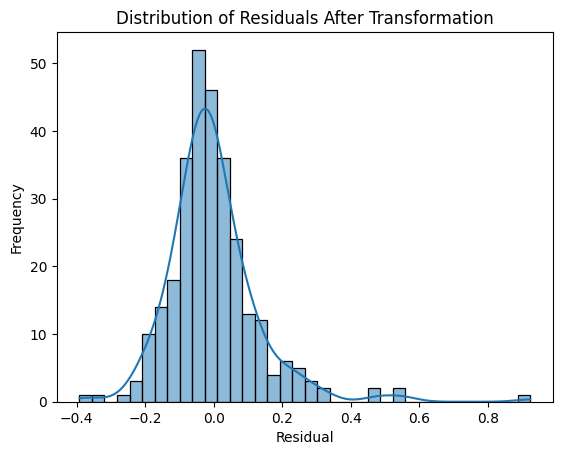

In [29]:
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals After Transformation")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.savefig(f"{plot_dir}/residual_dist_trans.png", bbox_inches ='tight')

## Polynomial Regression

In [30]:
# Με τα 34 αρχικά χαρακτηριστικά, τα χαρακτηριστικά που παράγονται είναι 2481256778 (n+d choose d)

init_n_feats = 34
degree = 10
math.comb(init_n_feats + degree, degree)    

2481256778

In [31]:
pca = PCA(n_components=5)
X_train_reduced = pca.fit_transform(X_train[selected_features_34])
X_test_reduced = pca.transform(X_test[selected_features_34])

In [32]:
# Με 5 αρχικά χαρακτηριστικά, τα χαρακτηριστικά που παράγονται είναι 3003

init_n_feats = 5
degree = 10
math.comb(init_n_feats + degree, degree)   

3003

In [33]:
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(X_train_reduced)

print(X_poly.shape[1])

3003


Degree 2, Train R²: 0.844 Test R²: 0.867, CV R²: 0.819±0.135
Degree 3, Train R²: 0.862 Test R²: 0.865, CV R²: 0.771±0.23
Degree 4, Train R²: 0.897 Test R²: 0.838, CV R²: 0.651±0.446
Degree 5, Train R²: 0.928 Test R²: 0.653, CV R²: 0.052±1.168
Degree 6, Train R²: 0.955 Test R²: -2.346, CV R²: -32.314±59.323
Degree 7, Train R²: 0.983 Test R²: -138.141, CV R²: -22507.025±55923.414
Degree 8, Train R²: 1.0 Test R²: -20378777.085, CV R²: -14664514.725±28554316.548
Degree 9, Train R²: 1.0 Test R²: -14021605.516, CV R²: -5.028536037512262e+18±1.50856081124709e+19
Degree 10, Train R²: 1.0 Test R²: -7970763.28, CV R²: -9.41091999665485e+18±2.8232759989952692e+19



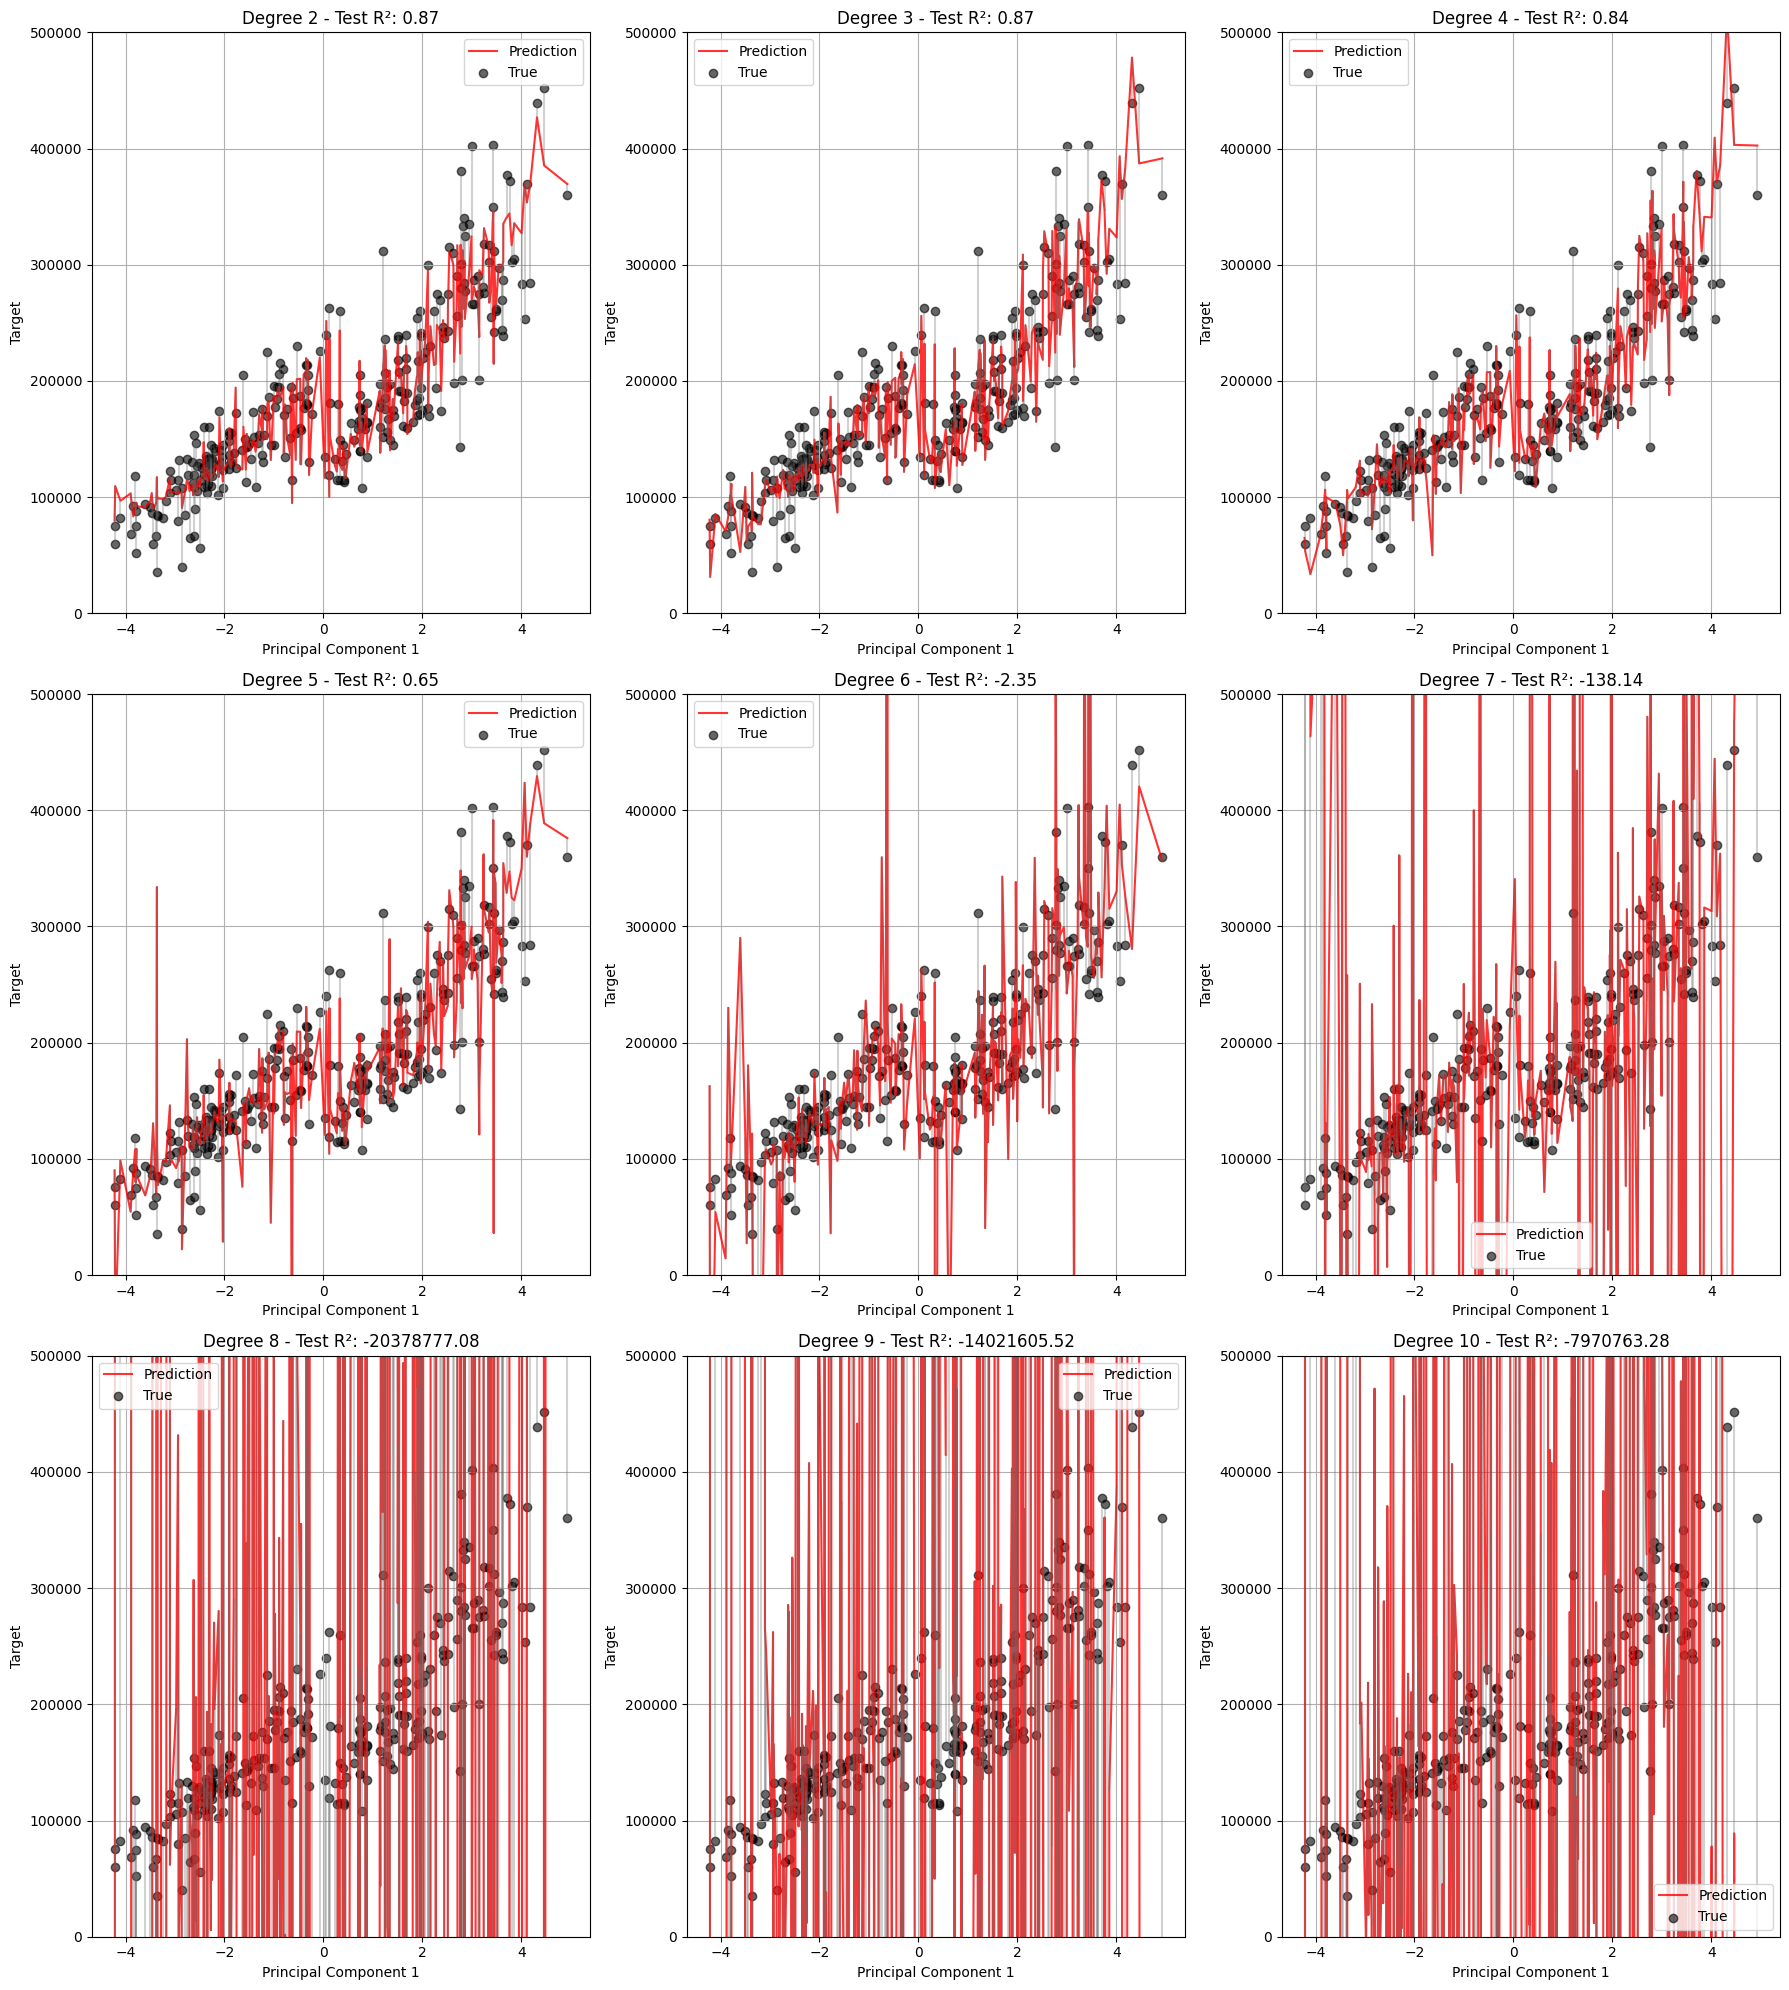

In [34]:
# Για κάθε βαθμό πολυωνύμου, κρατο΄ύνται τα scores και τα residuals (για plot, με γκρι γραμμη)
plt.figure(figsize=(18, 20))
degrees = list(range(2, 11))
cv_scores = []
residuals = []

for i, degree in enumerate(degrees, 1):
    polyreg = make_pipeline(
        PolynomialFeatures(degree),
        StandardScaler(),
        LinearRegression()
    )

    # cv score update
    scores = cross_val_score(polyreg, X_train_reduced, y_train, cv=kf)
    cv_scores.append(scores)

    # train and test scores 
    polyreg.fit(X_train_reduced, y_train)
    test_score = polyreg.score(X_test_reduced, y_test)
    train_score = polyreg.score(X_train_reduced, y_train)

    print(f"Degree {degree}, Train R²: {round(train_score,3)} Test R²: {round(test_score,3)}, CV R²: {round(scores.mean(),3)}±{round(scores.std(),3)}")

    # Predict and collect residuals
    y_pred = polyreg.predict(X_test_reduced)
    residual = y_pred - y_test
    residuals.append(residual)
    
    y_test_array = y_test.to_numpy()
    
    # In the loop:
    y_pred = polyreg.predict(X_test_reduced)
    residual = y_pred - y_test_array
    residuals.append(residual)
    
    # Visualize predictions vs PC1 with residual lines
    # sort για να προχωράει η γραμμη των προβλέψεων με τον άξονα του x 
    plt.subplot(3, 3, i)
    sorted_idx = np.argsort(X_test_reduced[:, 0])
    x_sorted = X_test_reduced[sorted_idx, 0]
    y_true_sorted = y_test_array[sorted_idx]
    y_pred_sorted = y_pred[sorted_idx]
    
    plt.plot(x_sorted, y_pred_sorted, color='red', label='Prediction', alpha=0.8)
    plt.scatter(x_sorted, y_true_sorted, alpha=0.6, color='black', label='True')
    
    # Draw residual lines
    for x, y_t, y_p in zip(x_sorted, y_true_sorted, y_pred_sorted):
        plt.plot([x, x], [y_t, y_p], color='dimgray', alpha=0.3)
    
    plt.title(f"Degree {degree} - Test R²: {test_score:.2f}")
    plt.ylim(0, 500000)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Target')
    plt.legend()
    plt.grid(True)
    
print()
plt.tight_layout()
plt.savefig(f"{plot_dir}/polynomial.png", bbox_inches ='tight')
plt.show()

In [35]:
# από τον βαθμό πολυωνύμου 2, παρατηρείται ήδη cv score σε ένα batch = 0.41762212
# προέρχεται από τα outlier του target σε αυτό το batch
degrees = list(range(2,11))
for degree, cv_score in zip(degrees, cv_scores):
    print(degree, '==========================================================================')
    print(cv_score)
print('=============================================================================')

2 ==========================================================================
[0.86675709 0.86293096 0.85699884 0.41762212 0.88132042 0.83436677
 0.84319433 0.873947   0.84112007 0.91103859]
3 ==========================================================================
[0.83135781 0.83430753 0.83576176 0.08366645 0.8840987  0.8413988
 0.83100995 0.82997277 0.84427405 0.8980805 ]
4 ==========================================================================
[ 0.82987867  0.71306667  0.7001284  -0.67429496  0.85320969  0.86980027
  0.78197369  0.80835438  0.75122097  0.87540653]
5 ==========================================================================
[ 7.75104561e-01  2.29965438e-03  5.76080152e-01 -3.30879770e+00
  7.03222709e-01  4.45459469e-01 -3.18721597e-01  6.93937153e-01
  3.15634630e-01  6.40654738e-01]
6 ==========================================================================
[-5.99203549e-02 -6.57547616e+00 -4.29127386e+00 -1.36724074e+02
 -7.77231818e-01 -2.73253408e+00 -1.63

## Lasso Regression

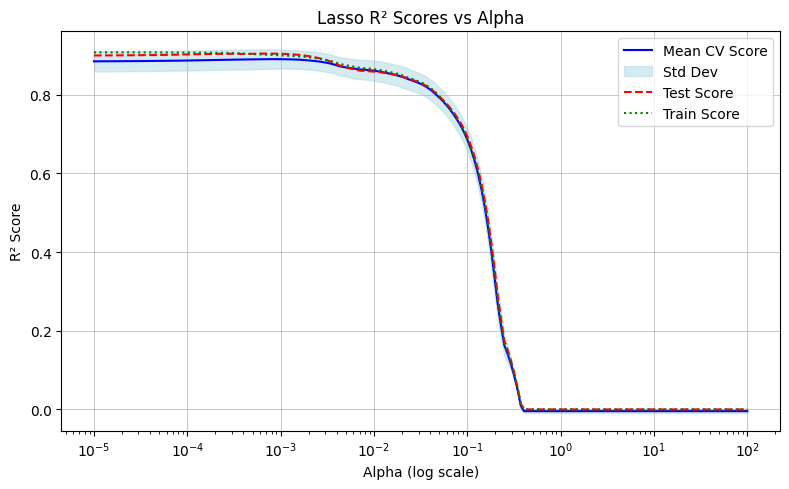

In [36]:
alphas = np.logspace(-5, 2, num=200)
mean_scores = []
std_scores = []
test_scores = []
train_scores = []
coefs = []  

for alpha in alphas:
    lasso = Lasso(alpha, max_iter=10000)
    scores = cross_val_score(lasso, X_train, y_train_log, cv=kf)

    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))
    
    lasso.fit(X_train, y_train_log)
    test_score = lasso.score(X_test, y_test_log)
    train_score = lasso.score(X_train, y_train_log)

    test_scores.append(test_score)
    train_scores.append(train_score)
    coefs.append(lasso.coef_)
    
# Plot με error bars
plt.figure(figsize=(8, 5))
# log x axis για τα alphas
plt.semilogx(alphas, mean_scores, label='Mean CV Score', color='blue')
plt.fill_between(alphas,
                 np.array(mean_scores) - np.array(std_scores),
                 np.array(mean_scores) + np.array(std_scores),
                 color='lightblue', alpha=0.5,
                 label='Std Dev')

plt.semilogx(alphas, test_scores, label='Test Score', color='red', linestyle='--')
plt.semilogx(alphas, train_scores, label='Train Score', color='green', linestyle=':')

plt.xlabel('Alpha (log scale)')
plt.ylabel('R² Score')
plt.title('Lasso R² Scores vs Alpha')
plt.grid(lw=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"{plot_dir}/lasso.png", bbox_inches ='tight')
plt.show()

In [37]:
test_scores = np.array(test_scores)
print(f"Best: {test_scores.argmax().item()}, Score {round(test_scores.max().item(),3)},\
 λ:{round(alphas[test_scores.argmax().item()],4)}, Cv Score {round(mean_scores[test_scores.argmax().item()],3)} ±\
 {round(std_scores[test_scores.argmax().item()],3)}, Train Score {round(train_scores[test_scores.argmax().item()],3)}")

Best: 54, Score 0.905, λ:0.0008, Cv Score 0.891 ± 0.024, Train Score 0.902


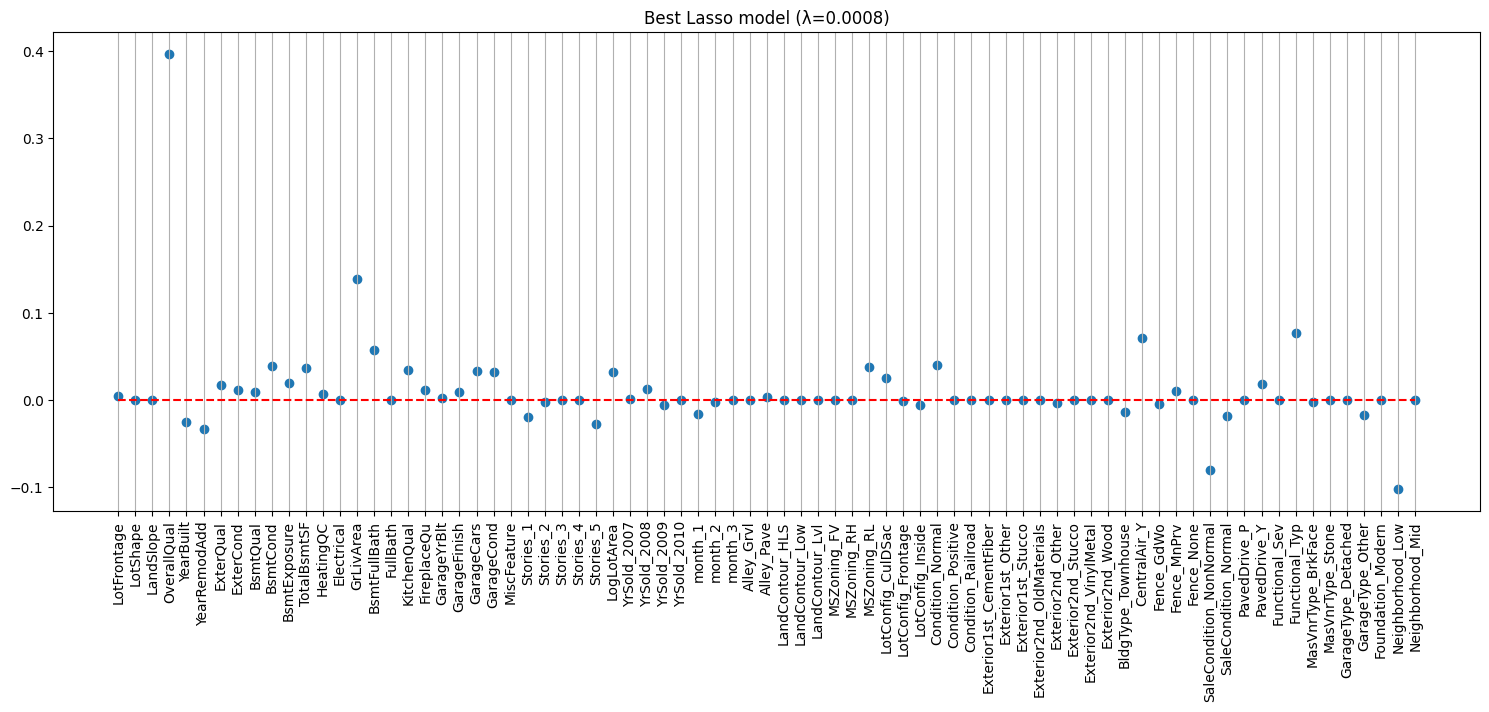

In [38]:
plt.figure(figsize=(15, 7))
plt.scatter(range(len(X_train.columns)), coefs[test_scores.argmax().item()])
plt.hlines(y=0, xmin=0, xmax=len(X_train.columns)-1, colors='red', linestyles='dashed')
plt.xticks(ticks=range(len(X_train.columns)), labels=X_train.columns, rotation=90)
plt.tight_layout()
plt.grid(axis='x')
plt.title("Best Lasso model (λ=0.0008)")

plt.savefig(f"{plot_dir}/lasso_best.png", bbox_inches ='tight')
plt.show()

In [39]:
def plot_coeffs(coefs, min_ind, max_ind, figsize=(8, 4), save=False, plot_dir=plot_dir):
    '''
    διάγραμμα Coef = f(alpha) για τα χαρακτηριστικά -> features[min_ind:max_ind]
    '''
    num_colors = max_ind-min_ind
    
    colors = mpl.colormaps['tab20'](np.linspace(0, 1, num_colors))
    coefs = np.array(coefs)  # shape: (n_alphas, n_features)
    
    plt.figure(figsize=figsize)
    for i in range(min_ind, max_ind):
        plt.semilogx(alphas, coefs[:, i], label=X_train.columns[i], color=colors[i-min_ind])
    
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("Coefficient Value")
    plt.title(f"Lasso Coefficient Paths for features {min_ind}-{max_ind-1}")
    plt.grid(linewidth=0.5)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout()
    if save:
        plt.savefig(f"{plot_dir}/{save}.png", bbox_inches ='tight')
    plt.show()

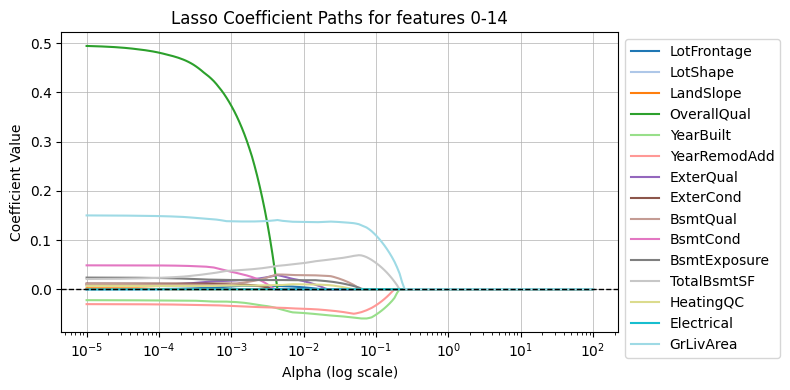

In [40]:
min_ind=0
max_ind=15
plot_coeffs(coefs, min_ind, max_ind, save='feats_0-15')

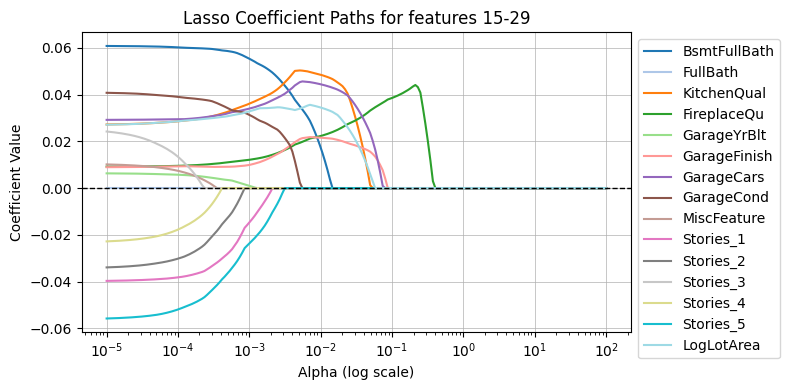

In [41]:
min_ind=15
max_ind=30
plot_coeffs(coefs, min_ind, max_ind, save='feats_15-30')

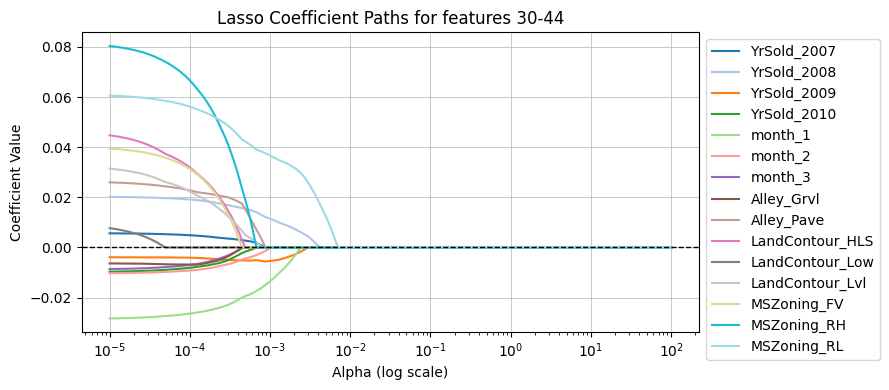

In [42]:
min_ind=30
max_ind=45
plot_coeffs(coefs, min_ind, max_ind, (9,4), save='feats_30-45')

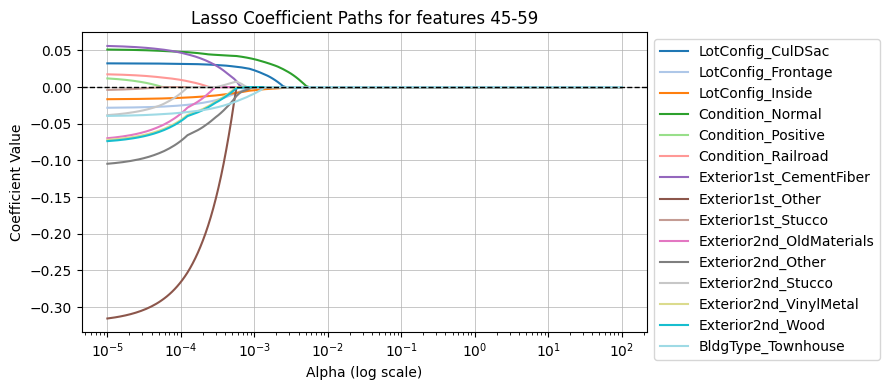

In [43]:
min_ind=45
max_ind=60
plot_coeffs(coefs, min_ind, max_ind, (9,4), save='feats_45-60')

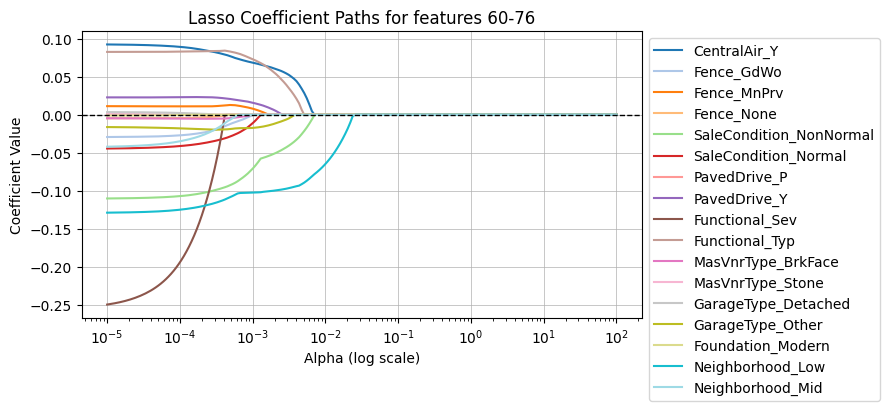

In [44]:
min_ind=60
max_ind=len(X_train.columns)
plot_coeffs(coefs, min_ind, max_ind, (9,4), save=f'feats_60-{max_ind}')

## MLPs

In [45]:
nn_one_layer = MLPRegressor(hidden_layer_sizes=(10), max_iter=10_000, random_state=42, learning_rate_init=0.1)
scores = cross_val_score(nn_one_layer, X_train[selected_features_34], y_train, cv=kf)

In [46]:
print(f"mean: {round(scores.mean().item(),4)}, std {round(scores.std().item(), 4)}")

mean: 0.8706, std 0.0522


In [47]:
nn_one_layer.fit(X_train[selected_features_34], y_train)
print(nn_one_layer.score(X_train[selected_features_34], y_train))
print(nn_one_layer.score(X_test[selected_features_34], y_test))

0.9160054284966388
0.8885180548044246


In [48]:
def plot_weights_and_biases(nn_model, layer_num, figsize=(12, 8), save=None, labels=None, plot_dir=plot_dir):
    '''
    Διάγραμμα heatmap με x axis νευρώνα του hidden layer = layer_num
    και y axis το χαρακτηριστικό. 
    Rows -> (bias, [features34], mean, std)
    Columns -> ([neurons], mean, std) 
    Mean και std μόνο όταν υπάρχουν πολύ νευρώνες στο hidden layer
    '''
    
    # συντελεστές και biases
    coefs = nn_model.coefs_[layer_num]  # Shape: (n_inputs, n_neurons)
    biases = nn_model.intercepts_[layer_num]  # Shape: (n_neurons,)

    # Labeling
    if labels is None:
        labels = [f'Feature {i+1}' for i in range(coefs.shape[0])]
    yticklabels = ['Bias'] + labels 
    xticklabels = [f'Neuron {i+1}' for i in range(coefs.shape[1])]

    # μόνο εάν περιλαμ΄βάνει παραπάνω από έναν νευρώνα 
    # υπολογίζονται και τα mean και biases χαρακτηριστικών και νευρώνων
    if nn_model.coefs_[layer_num].shape[1]>1:
        # mean and std των νευρώνων
        means = np.mean(coefs, axis=0)
        stds = np.std(coefs, axis=0)
        
        # biases στο πρώτο row
        biases = np.expand_dims(biases, axis=0)  # Shape: (1, 1)
        coefs = np.vstack([biases, coefs, means, stds])
        
        # mean std χαρακτηριστικών
        feature_means = np.mean(coefs, axis=1, keepdims=True)  # (n_inputs, 1)
        feature_stds = np.std(coefs, axis=1, keepdims=True)    # (n_inputs, 1)
    
        # mean και std δυο τελευταία columns
        coefs = np.hstack([coefs, feature_means, feature_stds])  # (n_inputs, n_neurons+2)

        xticklabels += ['Mean', 'Std']
        yticklabels += ['Mean', 'Std']
        
    else:     
        coefs = np.vstack([biases, coefs])  # (n_inputs+1, n_neurons+2)


    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(coefs, cmap='coolwarm', annot=True, fmt='.2f',
                xticklabels=xticklabels, yticklabels=yticklabels,
                cbar_kws={'label': 'Weight Value'})

    plt.title(f"Heatmap of Weights Layer Number {layer_num}")
    plt.xlabel("Neuron")
    plt.ylabel("Features")
    plt.tight_layout()

    if save:
        plt.savefig(f"{plot_dir}/{save}.png", bbox_inches='tight')
    plt.show()


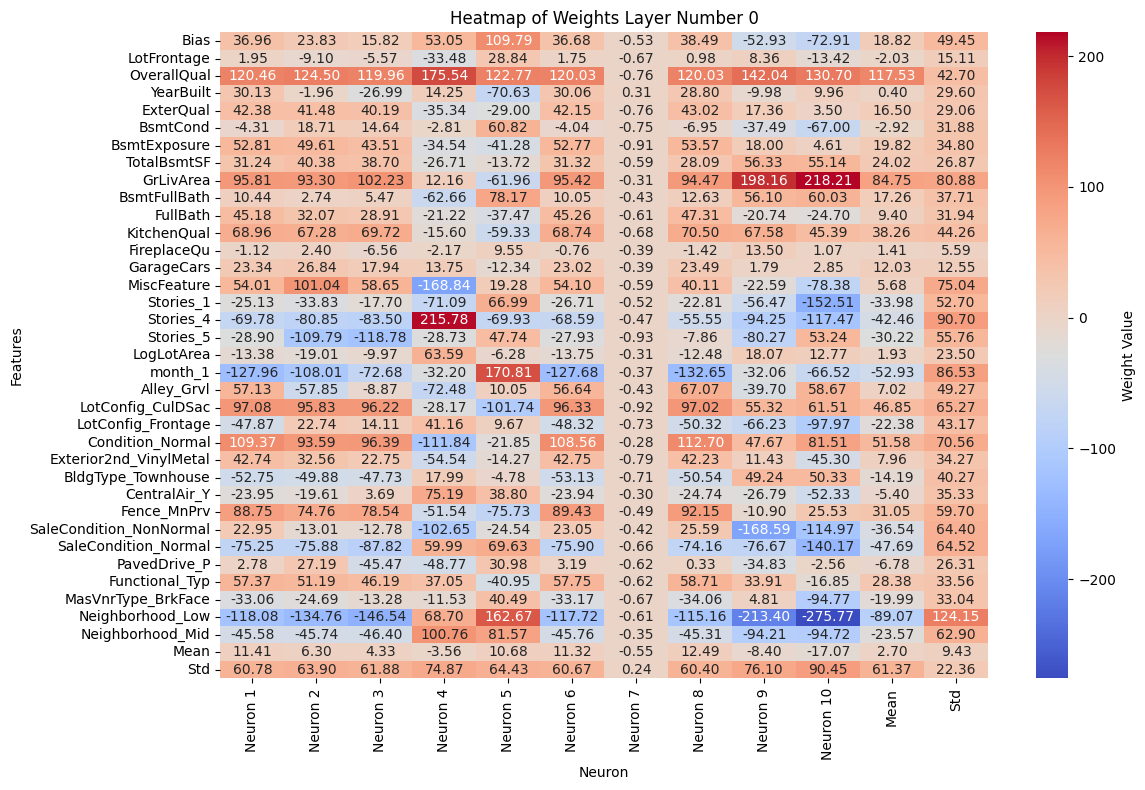

In [49]:
plot_weights_and_biases(nn_one_layer, 0, save='1layer_1rst', labels=selected_features_34)

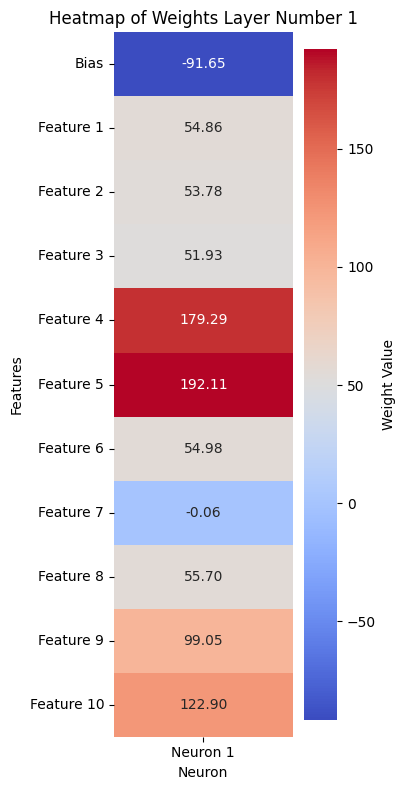

In [50]:
plot_weights_and_biases(nn_one_layer, 1, figsize=(4,8), save='1layer_2nd')

1 Neuron: training outputs 23621±13207
2 Neuron: training outputs 20666±14019
3 Neuron: training outputs 17375±13865
4 Neuron: training outputs 14299±15933
5 Neuron: training outputs 40094±25615
6 Neuron: training outputs 23584±13201
7 Neuron: training outputs -92±0
8 Neuron: training outputs 24833±13323
9 Neuron: training outputs 12082±21641
10 Neuron: training outputs 3256±11963


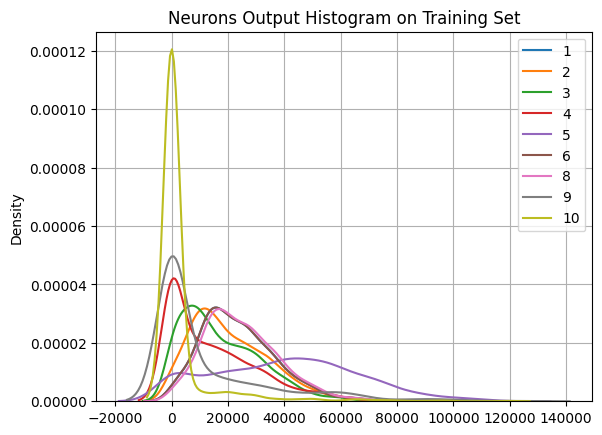

In [57]:
# Forward pass κάθε μεμονωμένου νευρώνα
layer_num=0
n_neurons = nn_one_layer.coefs_[layer_num].shape[1]
for i in range(n_neurons):
    # Βάρη και bias του layer 
    weights = nn_one_layer.coefs_[0][:,i]
    intercept = nn_one_layer.intercepts_[0][i].item()

    # preactivated τιμή του νευρώνα
    pre_act =  X_train[selected_features_34]@weights + intercept
    # activation με ReLU
    activated = list(map(lambda x_i: max(0, x_i), pre_act))

    # weights και intercept του output layer
    weight_out = nn_one_layer.coefs_[1][i]
    intercept_out = nn_one_layer.intercepts_[1]

    # Στο output layer δεν υπάρχει activation function
    final_val = activated*weight_out + intercept_out
    mean = final_val.mean()
    std = final_val.std()
    print(f"{i+1} Neuron: training outputs {round(mean)}±{round(std)}")
    if std != 0:
        sns.kdeplot(x = final_val, label=i+1)
plt.grid()
plt.title("Neurons Output Histogram on Training Set")
plt.legend()
plt.savefig(f"{plot_dir}/outhistnn.png", bbox_inches='tight');

In [58]:
nn_two_layer = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=10_000, random_state=42, learning_rate_init=0.1)
scores = cross_val_score(nn_two_layer, X_train[selected_features_34], y_train, cv=kf)

In [59]:
scores

array([0.89387444, 0.87181404, 0.87864019, 0.608502  , 0.90514954,
       0.89536168, 0.88661319, 0.8640251 , 0.86877409, 0.94106852])

In [60]:
print(f"mean: {round(scores.mean().item(),4)}, std {round(scores.std().item(), 4)}")

mean: 0.8614, std 0.0869


In [61]:
nn_two_layer.fit(X_train[selected_features_34], y_train)
print(nn_two_layer.score(X_train[selected_features_34], y_train))
nn_two_layer.score(X_test[selected_features_34], y_test)

0.9235853279706818


0.8896922975013716

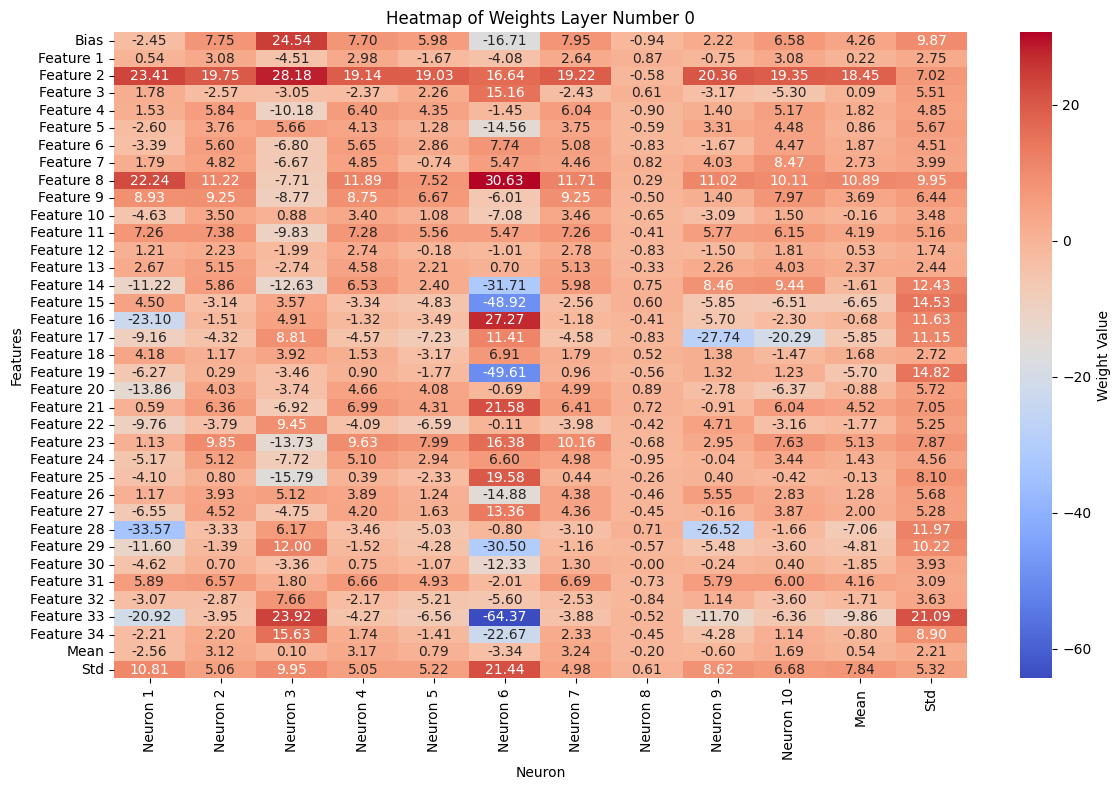

In [62]:
plot_weights_and_biases(nn_two_layer, 0)

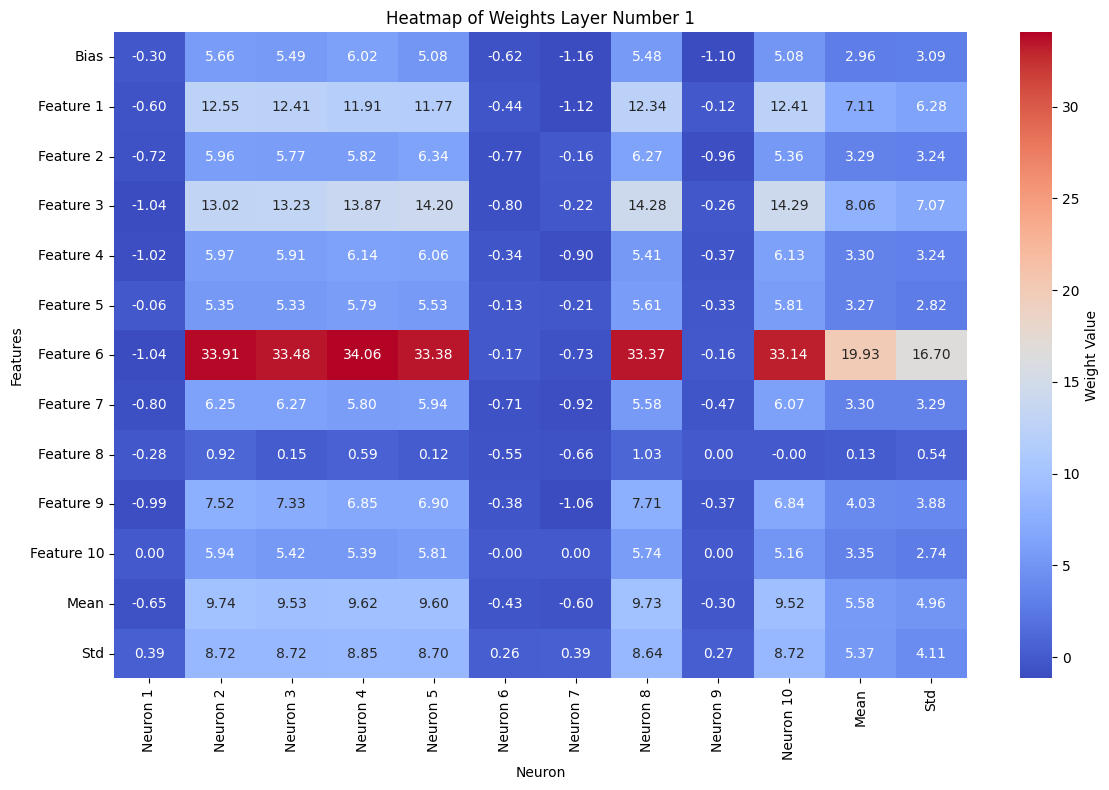

In [63]:
plot_weights_and_biases(nn_two_layer, 1)

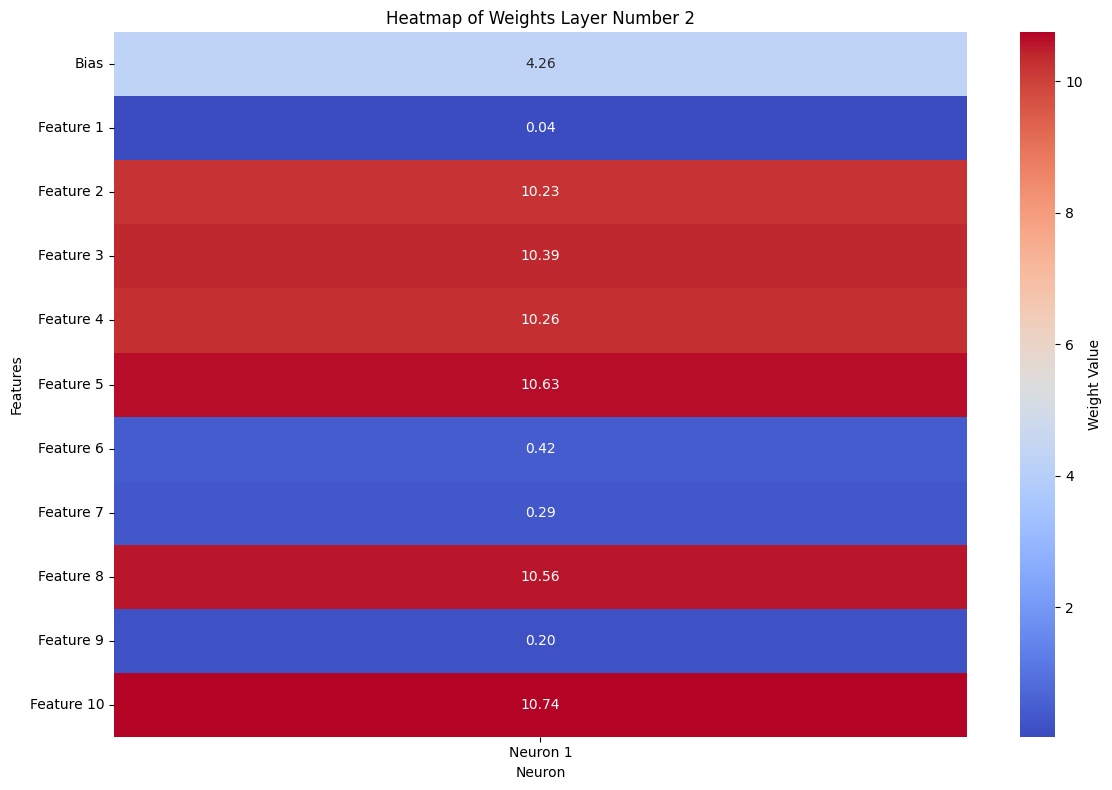

In [64]:
plot_weights_and_biases(nn_two_layer, 2)

## Gaussian Processes

In [65]:
def plot_gp(model, n_points=50, save=False, label="SalePrice", X_test=X_test, y_test=y_test, ampl = 1e5, str_amp = '1e5'):
    # predictions με std στο test set
    y_pred_test, y_std_test = model.predict(X_test[selected_features_34], return_std=True)
    
    # DataFrame με test data και τις προβλέψεις
    test_data = pd.DataFrame({
        'GrLivArea': X_test['GrLivArea'],
        'y_pred': y_pred_test,
        'y_std': y_std_test * ampl
    }).sort_values('GrLivArea')
    
    # Επιλογή sample για visualization 
    subsampled = test_data.iloc[::(len(test_data)//n_points or 1)].copy()
        
    # Plot predictions με uncertainty
    plt.figure(figsize=(10, 6))
    plt.plot(subsampled['GrLivArea'], subsampled['y_pred'], 'b-', lw=2, label='GP Prediction')
    plt.fill_between(subsampled['GrLivArea'],
                     subsampled['y_pred'] - 2 * subsampled['y_std'],
                     subsampled['y_pred'] + 2 * subsampled['y_std'],
                     color='blue', alpha=0.2, label=f'95% CI (scaled x{str_amp})')
    
    # Plot τις αντίστοιχες ground truth values
    mask = X_test['GrLivArea'].isin(subsampled['GrLivArea'])
    plt.scatter(X_test.loc[mask, 'GrLivArea'], y_test[mask], alpha=0.5, c='gray', label='Test data')
    
    # plot
    plt.xlabel("GrLivArea")
    plt.ylabel(label)
    plt.title(f"GrLivArea vs {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    if save:
        plt.savefig(f"{plot_dir}/{save}.png", bbox_inches='tight')
    plt.show()

In [66]:
kernel_linear = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e9))

gp_linear = GaussianProcessRegressor(kernel=kernel_linear, random_state=42)
gp_linear.fit(X_train[selected_features_34], y_train)

y_pred_linear = gp_linear.predict(X_test[selected_features_34])
scores = cross_val_score(gp_linear, X_train[selected_features_34], y_train, cv=kf)

r2_linear = r2_score(y_test, y_pred_linear)
print("Linear Kernel R²:", r2_linear, "CV R²:", scores.mean(), '±', scores.std())

Linear Kernel R²: 0.8707027682372248 CV R²: 0.836313538933522 ± 0.04343400305788383


In [67]:
kernel_linear = DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-5, 1e9))

gp_log_linear = GaussianProcessRegressor(kernel=kernel_linear, random_state=42)
gp_log_linear.fit(X_train[selected_features_34], y_train_log)

y_pred_linear = gp_log_linear.predict(X_test[selected_features_34])
y_pred_linear_train = gp_log_linear.predict(X_train[selected_features_34])

scores = cross_val_score(gp_log_linear, X_train[selected_features_34], y_train_log, cv=kf)

train_score = r2_score(y_train_log, y_pred_linear_train)
r2_linear = r2_score(y_test_log, y_pred_linear)
print("Linear Kernel R²:", round(r2_linear,3), "CV R²:", round(scores.mean(),3), '±', round(scores.std(),3),\
      'Train R²:', round(train_score,3))

Linear Kernel R²: 0.897 CV R²: 0.889 ± 0.026 Train R²: 0.897


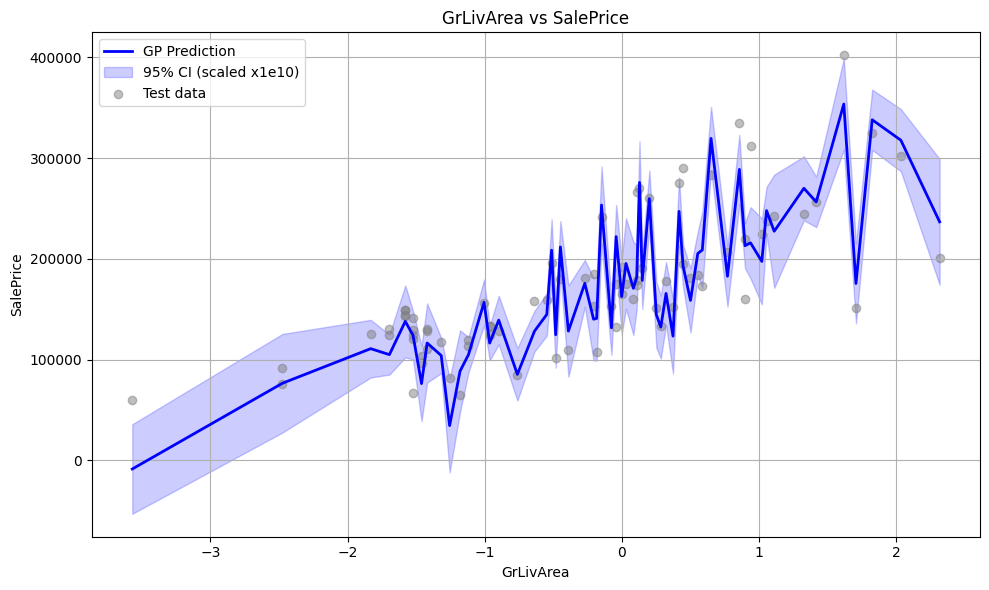

In [68]:
plot_gp(gp_linear, y_test=y_test, ampl=1e10, str_amp='1e10')

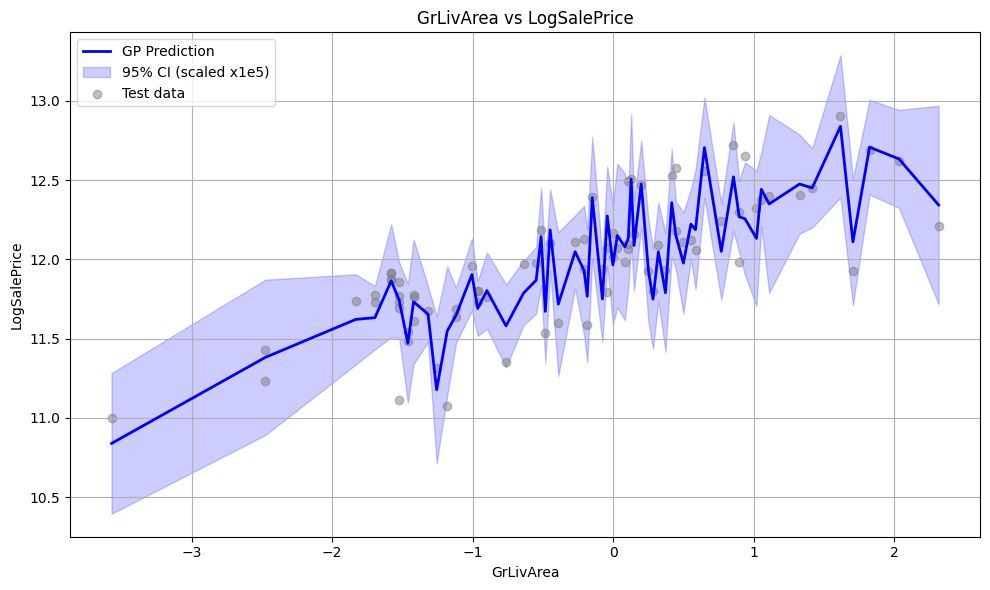

In [69]:
plot_gp(gp_log_linear, label='LogSalePrice', y_test=y_test_log, save= 'gplin')

In [ ]:
# grid search σε επίπεδο θορυβου και τιμή σίγμα

noise_levels = [0, 1e-5, 1e-3, 1e-1, 1, 1e1]
sigma_values = [1e-2, 1e-1, 1, 1e1, 1e2]

r2_cv = {}
r2_test = {}
best_model = None
max_score = 0
for nl in noise_levels:
    r2_cv[nl] = {}
    r2_test[nl] = {}
    print(f"Noise level: {nl}")
    for sigma in sigma_values:
        kernel_rbf = RBF(length_scale=sigma) + WhiteKernel(noise_level=nl, noise_level_bounds="fixed")
        gp = GaussianProcessRegressor(kernel=kernel_rbf, random_state=42)
        scores = cross_val_score(gp, X_train[selected_features_34], y_train, cv=kf)
        
        gp.fit(X_train[selected_features_34], y_train)
        score = gp.score((X_test[selected_features_34]), y_test)
        train_score = gp.score((X_train[selected_features_34]), y_train)
        r2_cv[nl][sigma] = scores.mean()
        r2_test[nl][sigma] = score
        
        print(f"\tσ:{sigma}\t|R² Train score: {train_score:.4f}\t|R² Test score: {score:.4f}\t|CV R² Score: {round(scores.mean(), 4)}±{round(scores.std(), 4)}")

        if not best_model or score>max_score:
            best_model = gp
            max_score = score

Noise level: 0


In [ ]:
plot_gp(best_model, y_test=y_test, ampl=2e4, str_amp='2e4', save='gprbf')